# Sea level budget

In [1]:
import sys
sys.path.append('../code')
import importlib
from time import gmtime, strftime

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import xarray as xr
import IPython.display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
#import netCDF4

import SeaLevelContrib as slc

In [32]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '../code/SeaLevelContrib.py'>

In [3]:
path_outputs = '../outputs/'

### Namelist

In [37]:
# Pick a region name (see choices bellow): 
tg_sel = 'ZSM' # Tide gauge selection, see options in the next cell
opt_steric = ['EN4','ENS',2000] 
                # [0]: Poduct, 'EN4' and 'IAP' available so far
                # [1]: Region on which to average the steric effect: 
                # ENS: Extended North Sea, 
                # EBB: Extended Bay of Biscay 
                # NWS: Norwegian Sea
                # [2]: Depth of integration in meters
opt_glaciers = 'fred20' # fred20
                            # marzeion15 for Marzeion et al. 2015
                            # zemp19 for Zemp et al. 2019
opt_antarctica = 'fred20' # rignot19, imbie18, fred20
opt_greenland = 'fred20' # mouginot19, fred20
                             # IMBIE is used in Greenland.ipynb but not yet implemented here
opt_tws = 'fred20' # humphrey19 for Humphrey and Gudmundson 2019
                       # fred20 for Frederikse et al. 2020
#!!! Nodal cycle only included for regression method, not yet for dynamical model
opt_wind_ibe = ['dynamical_model','GTSM'] # Method 'regression' or 'dynamical_model' 
                          # 'NCEP1': Regression to NCEP1 (1948 to now)
                          # 'ERA5' : Regression to ERA5 (1979 to now)
                          # 'WAQUA' : Use the barotropic ocean model WAQUA
                          # 'GTSM': Use the barotropic ocean model GTSM
opt_nodal = 'potential' # 'potential' or 'regression', 'regression' only available 
                         #if opt_wind_ibe[0] is also 'regression'
global_steric = 'fred20' # None for no splitting between global and local
                     # 'levitus' or 'fred20' otherwise
INFO = True # Additional info on the computations

In [38]:
reg_dict = {'ZSM' : [20, 22, 23, 24, 25, 32], # Zeespiegelmonitor (Dutch coast)
            # North Sea Frederikse et al. 2016
            'NS_Fred16': [20, 32, 236, 7, 80, 89, 302, 47, 830, 361, 95, 754],
            'Newlyn': [202], 
            'Brest': [1], 
            'Vlissingen': [20]}

tg_id = reg_dict[tg_sel]
tg_id

[20, 22, 23, 24, 25, 32]

### Budget

In [39]:
# Check the tide gauge data
tg_df = slc.tide_gauge_obs(tg_id, interp=True)
tg_df.iloc[-10:]

,20,22,23,24,25,32,Average
time,,,,,,,
2009,12.172611,14.848387,8.513636,10.288312,7.905195,9.902721,10.605144
2010,12.372611,15.748387,7.213636,8.888312,5.705195,8.702721,9.771810
2011,12.772611,16.348387,11.913636,14.388312,12.305195,11.802721,13.255144
2012,12.072611,16.348387,10.413636,12.788312,11.005195,11.202721,12.305144
2013,10.672611,14.748387,7.513636,10.388312,6.705195,8.802721,9.805144
2014,14.472611,17.848387,10.813636,14.788312,12.005195,13.502721,13.905144
2015,14.772611,18.648387,13.813636,20.088312,16.705195,14.902721,16.488477
2016,15.072611,18.848387,11.913636,16.588312,13.005195,14.202721,14.938477
2017,16.672611,21.048387,15.813636,22.388312,17.605195,17.202721,18.455144


In [40]:
slmean_df = slc.budget_at_tg(INFO, tg_id, opt_steric, opt_glaciers, opt_antarctica, 
                             opt_greenland, opt_tws, opt_wind_ibe, opt_nodal, 
                             global_steric, True)

#slmean_df = slmean_df.loc[1958:2014] # Select date to fit Fred16 study
#slmean_df = slmean_df.loc[1993:]


/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Working on tide gauge id: 20
Working on tide gauge id: 22
Working on tide gauge id: 23
Working on tide gauge id: 24
Working on tide gauge id: 25
Working on tide gauge id: 32


In [41]:
slmean_df.iloc[0:10]

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,WindPressure,Obs
time,,,,,,,,,,,
1979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1980,0.486687,0.191122,0.313070,0.036833,0.033333,0.003333,0.004167,0.207500,0.058889,-0.361560,2.733333
1981,5.611267,1.717924,0.275575,0.073667,0.068333,0.010000,0.010000,0.258333,0.171871,3.025564,6.133333
1982,2.780310,1.580928,0.143674,0.110500,0.101667,0.012500,0.014167,0.116667,0.326189,0.374018,3.766667
1983,6.917156,1.969322,0.001053,0.147333,0.118333,0.020000,0.010000,0.125000,0.504421,4.021693,7.516667
1984,2.452121,2.019018,0.029940,0.184167,0.155833,0.022500,0.010000,-0.018333,0.686440,-0.637443,1.283333
1985,2.586628,1.424547,0.197717,0.221000,0.189167,0.030000,0.010833,-0.149167,0.851695,-0.189165,1.583333
1986,3.549190,1.470592,0.365359,0.257833,0.210000,0.032500,0.014167,-0.131667,0.981526,0.348879,0.933333
1987,4.442627,4.519882,0.348125,0.294667,0.235000,0.038333,0.014167,0.307500,1.061275,-2.376323,0.183333


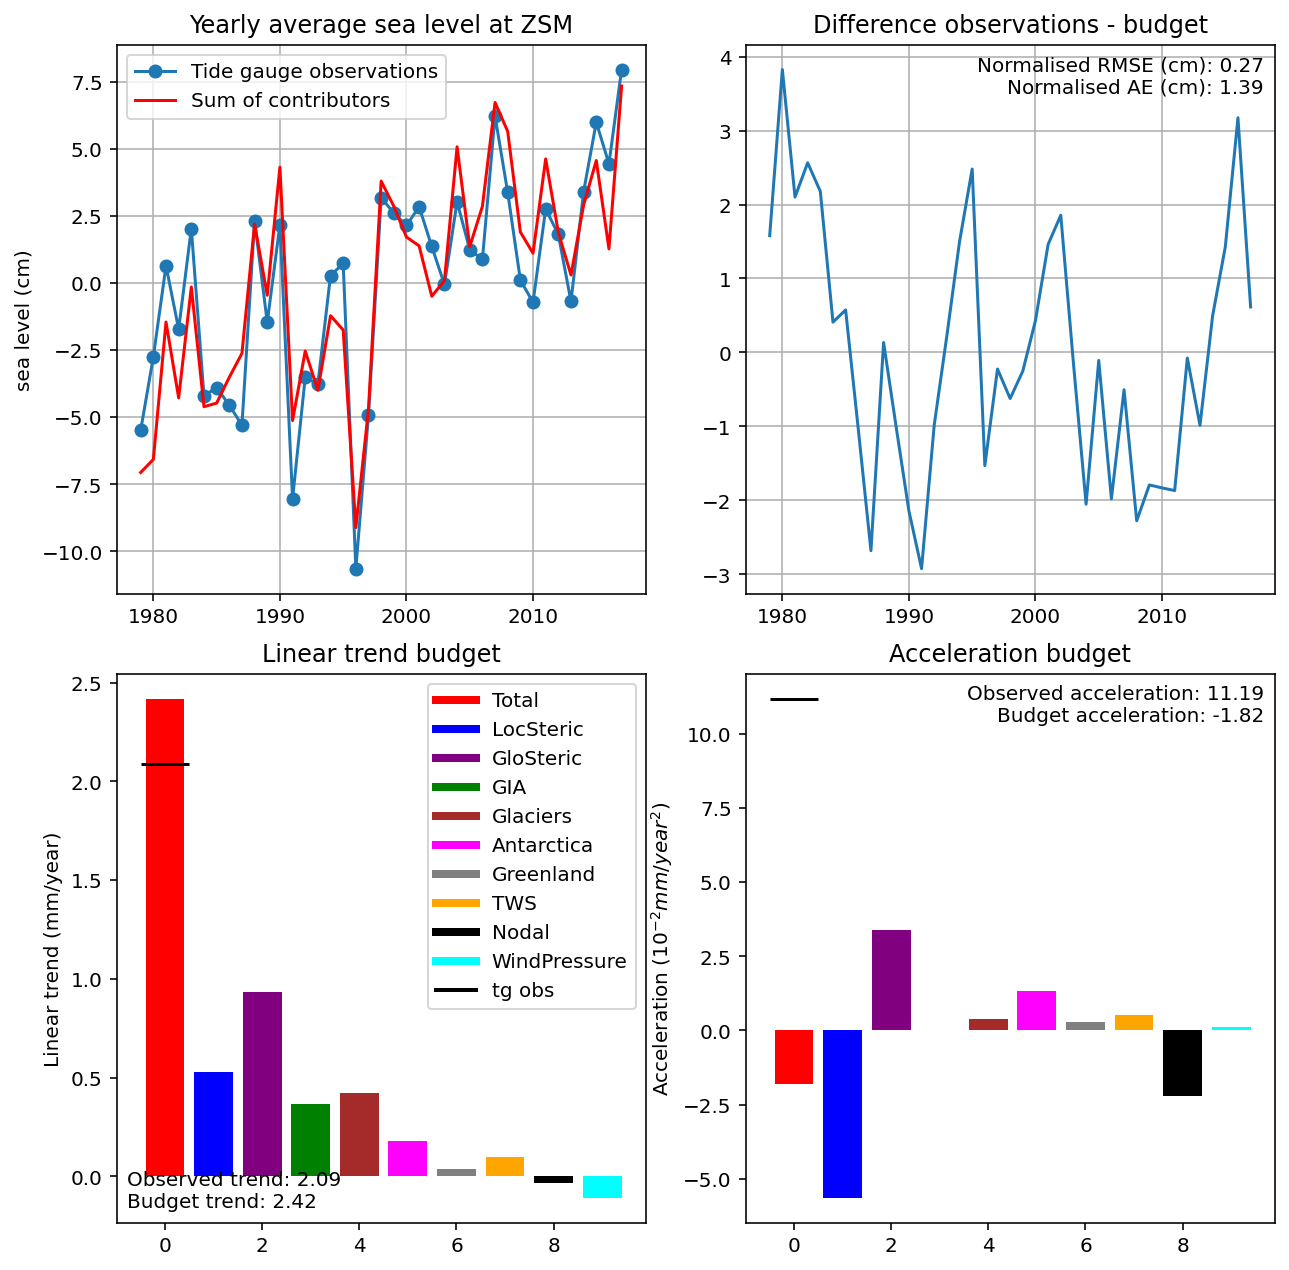

In [42]:
fig, ax = slc.plot_budget(tg_sel, slmean_df)

In [22]:
#slmean_df.plot(figsize=(9,9) )

In [36]:
budget_name = (f'slbudget_{strftime("%Y_%m_%d", gmtime())}_{tg_sel}_'+
               f'{slmean_df.index[0]}_{slmean_df.index[-1]}_{opt_wind_ibe[1]}'+
               f'Steric{opt_steric[0]}_{opt_steric[2]}m')

# Write out a budget csv file
slmean_df.to_csv(path_outputs+budget_name+'.csv')

# Write out the figure
fig.savefig(path_outputs+budget_name+'.pdf', bbox_inches='tight') #pad_inches=2

# Write budget info to a text file
text_out = ('Budget information: \n'
            'Tide gauge selection: '+tg_sel+' \n'
            'Corresponding to ids: '+str(tg_id)+' \n'
            'Period: '+str(slmean_df.index[0])+'-'+str(slmean_df.index[-1])+' \n'
            'Steric contribution: '+str(opt_steric)+' \n'
            'Global steric: '+global_steric+' \n'
            'Glaciers: '+opt_glaciers+' \n'
            'Antarctica:'+opt_antarctica+' \n'
            'Greenland: '+opt_greenland+' \n'
            'Terrestrial water storage: '+opt_tws+' \n'
            'Wind and inverse barometer effect: '+str(opt_wind_ibe)+' \n'
           )

file = open(path_outputs+budget_name+'.txt','w') 
file.write(text_out)
file.close()

# Alternative for better tracability but less lisibility:
# Generate a unique number that describes the budget, number the options and give an order:21324

### Some remarks

Comment on the choice of steric expansion location:
It seems that using the Bay of Biscay reduces the eror compared to extended North Sea.
On the other hand Norwegian Sea increases it.

Antarctica: 
Rignot et al. 2019 -> 0.315, 1.96
IMBIE 2018 -> 0.319, 1.99
More acceleration seems better

Using pressure as a regressor improves the budget closure. N. RMS: 0.308, N. AE: 1.93 

I had forgotten to add the nodal cycle. Including it improves the fit!

Computing the wind, nodal and pressure effects (linear fit) after removing the trend from the reconstruction improves the fit compared to computing the fit using a linear trend.

Using ERA5 leads to improve the model significantly, for the period 1979 and after:
- ERA5: rmse = 0.21, ae = 1.08
- NCEP1: rmse = 0.24, ae = 1.21

Using the extended Bay of Biscay area, mostly solves the trend problem but it introduces higher rms (0.27) and ae (1.30).

The same conclusion applies to stopping the integration of steric effect at 60N instead of the standard 69N. This is because steric trend in the region 60-69 is smaller than further South (see the Steric notebook). What is the most relevent for the North Sea?

Using sea level from WAQUA forced by ERA-interim increases the rmse (0.26) and ae (1.35) compared to linear regressions to ERA5 or NCEP1 reanalysis. This might be because of sea level variations external to the domain entering the domain.

One possible difference between KNMI projections and Deltares zsm is the vertical land motion: GIA from ICE6G provides 0.36mm/y for the Dutch tide gauges while 0.45 was used in the ZSM. That is still not much: 2 mm in 20 years.

The computation of acceleration is very sensitive to the period used to compute it even for the steric effect. Also it seems very difficult to get right. For example at the Brest tide gauge, observations show a deceleration while the budget shows an acceleration.
This points toward the need to consider longer time periods to study the acceleration.

Even in the period 1950-2017 the acceleration is difficult to get right. For the Dutch coast the budget gives twice larger values than the tide gauge observations. For that period it seems that for Newlyn, Brest and Dutch coast the trend is underestimated and the acceleration is overestimated.

Acceleration for the Dutch coast is very sensitive to the wind and steric effects: check starting point in 1950 compared to 1958 -> Also check over the ERA5 period